In [137]:
import pandas as pd
import numpy as np
from station import Station
import seaborn as sns
import matplotlib.pyplot as plt
%load_ext autoreload
%autoreload
import geopy.distance
import descartes
import geopandas as gpd
from shapely.geometry import Point, Polygon
import pysal

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


/Users/djb326/.pyenv/versions/3.6.7/lib/python3.6/site-packages/pysal/__init__.py:65: VisibleDeprecationWarning: PySAL's API will be changed on 2018-12-31. The last release made with this API is version 1.14.4. A preview of the next API version is provided in the `pysal` 2.0 prelease candidate. The API changes and a guide on how to change imports is provided at https://pysal.org/about
  ), VisibleDeprecationWarning)


In [114]:
# read in data files
ride_df = pd.read_csv('data/CTA_-_Ridership_-__L__Station_Entries_-_Daily_Totals.csv')
map_df = pd.read_csv('data/CTA_-_System_Information_-_List_of__L__Stops.csv')
station_map_names = {'Lake':'Lake/State', 'Jackson':'Jackson/State',
                     'Washington':'Washington/Dearborn'}
map_df.replace({"STATION_NAME": station_map_names}, inplace=True)

In [115]:
station_list = ride_df.stationname.unique().tolist()
sumlist = []
for station in station_list:
    stat = Station(station, ride_df, map_df)
    sumlist.append(stat.summary)
station_summary = pd.DataFrame(sumlist)    
station_summary.to_csv('data/station_summary.csv')

In [116]:
station_summary = pd.read_csv('data/station_summary.csv')
to_remove = station_summary[station_summary['Sat_mean'] == 0].index[0]
station_summary.drop([to_remove], inplace=True)

station_summary['weekday-sat'] = station_summary['Weekday_mean'
                                                ] - station_summary['Sat_mean']

station_summary['weekday-sun'] = station_summary['Weekday_mean'
                                                ] - station_summary['Sun/Hol_mean']

In [117]:
high_stds = station_summary.sort_values(by='daily_std', ascending=False).iloc[0:10]
high_stations = high_stds.station.tolist()
high_stds.set_index('station', inplace=True)

In [118]:
high_stds

,Unnamed: 0,5_yr_num_diff,5_yr_pct_diff,Sat_mean,Sat_std,Sun/Hol_mean,Sun/Hol_std,Weekday_mean,Weekday_std,daily_mean,daily_std,latitude,longitude,num_na,num_yrs_from_past_5,weekday-sat,weekday-sun
station,,,,,,,,,,,,,,,,,
Clark/Lake,133,328.064384,0.021431,5112.702970,1882.363586,3906.938976,1620.315830,17965.562822,2868.452479,13901.899061,6714.698839,41.885737,-87.630886,0,5,12852.859852,14058.623846
Lake/State,65,587.442466,0.037362,9571.792079,4048.143372,6495.524606,3079.711894,16201.980739,4412.254604,13715.501721,5700.114941,41.884809,-87.627813,0,5,6630.188660,9706.456133
Jackson/State,95,-172.326712,-0.018835,4637.107811,1676.940372,3270.569882,1944.973115,11034.135274,1996.195230,8889.740845,3820.036582,41.878183,-87.629296,0,5,6397.027464,7763.565392
Washington/State,131,NaN,NaN,2842.545238,2136.088634,1700.389362,1361.260569,5975.798352,3890.640503,4849.686421,3814.963167,41.883100,-87.628700,0,0,3133.253114,4275.408990
Addison-North Main,44,41.748630,0.006135,7619.935094,4394.887829,5958.964567,4014.788301,7601.236058,3333.569089,7342.777465,3665.011920,41.947200,-87.653600,0,5,-18.699035,1642.271491
95th/Dan Ryan,14,743.466121,0.143039,7363.202210,1368.760161,5505.200000,1109.301992,12508.819123,2479.628887,10664.410535,3593.754973,41.722377,-87.624342,90,5,5145.616913,7003.619123
Washington/Wabash,147,NaN,NaN,5029.937500,2173.264555,3396.346154,1603.318261,8916.081197,3035.752612,7498.233533,3525.173041,41.883220,-87.626189,0,1,3886.143697,5519.735043
Washington/Dearborn,107,511.546575,0.054365,4181.415842,1760.111601,2793.965551,1438.873526,9684.427548,1987.502040,7806.032081,3443.689554,41.883164,-87.629440,0,5,5503.011706,6890.461996
Fullerton,99,-331.433562,-0.028854,7938.625963,2069.989985,5639.638780,1808.081373,11795.118253,2600.911912,10267.807042,3415.141617,41.925051,-87.652866,0,5,3856.492290,6155.479474


In [119]:
for stat in high_stations:
    stat = Station(stat, ride_df, map_df)
    stat.make_layered_hist('daytype')

hist_Clark_Lake_daytype.png
hist_Lake_State_daytype.png
hist_Jackson_State_daytype.png
hist_Washington_State_daytype.png
hist_Addison-North Main_daytype.png
hist_95th_Dan Ryan_daytype.png
hist_Washington_Wabash_daytype.png
hist_Washington_Dearborn_daytype.png
hist_Fullerton_daytype.png
hist_Monroe_State_daytype.png


<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

In [120]:
for stat in high_stations:
    stat = Station(stat, ride_df, map_df)
    stat.make_layered_hist('season')

hist_Clark_Lake_season.png
hist_Lake_State_season.png
hist_Jackson_State_season.png
hist_Washington_State_season.png
hist_Addison-North Main_season.png
hist_95th_Dan Ryan_season.png
hist_Washington_Wabash_season.png
hist_Washington_Dearborn_season.png
hist_Fullerton_season.png
hist_Monroe_State_season.png


<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

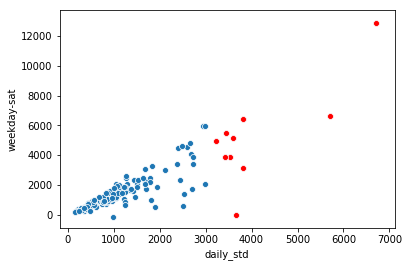

In [121]:
fig, ax = plt.subplots()
sns.scatterplot(x="daily_std", y="weekday-sat", data=station_summary, ax=ax)
sns.scatterplot(x="daily_std", y="weekday-sat", data=high_stds, color='red', ax=ax)

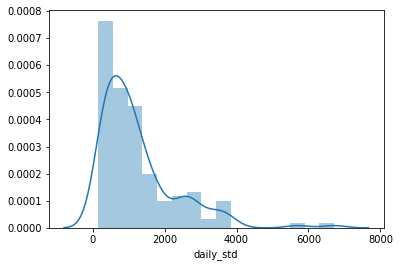

In [122]:
sns.distplot(station_summary['daily_std'])

In [123]:
# create geodataframe from stations with highest STDs
geometry = [Point(x,y) for x,y in zip(high_stds['longitude'], high_stds['latitude'])]
crs = {'init':'epsg:4326'}
geo_df = gpd.GeoDataFrame(index=high_stds.index, crs=crs, geometry=geometry)

In [124]:
neigh_map = gpd.read_file(
    'data/Boundaries - Community Areas/geo_export_c539fca7-2c77-4148-be09-2c656a4bc388.shp')
# get representative coordinates from each neighborhood
neigh_map['coords'] = neigh_map['geometry'].apply(
    lambda x: x.representative_point().coords[:])
neigh_map['coords'] = [coords[0] for coords in neigh_map['coords']]
neigh_map.set_index('community', inplace=True)

In [125]:
assign_dict = {key: geom for key, geom in neigh_map['geometry'].items()}
assign_dict2 = {key: geo_df.within(geom) for key, geom in assign_dict.items()}
# check which neighborhood each station falls in
station_to_neigh = geo_df.assign(**assign_dict2)
station_to_neigh = station_to_neigh.loc[:, (station_to_neigh != 0).any(axis=0)]

In [126]:
ncols = ['LAKE VIEW', 'LOOP', 'ROSELAND', 'LINCOLN PARK']
station_to_neigh['neighborhood'] = station_to_neigh[ncols].idxmax(axis=1)
station_to_neigh.drop(columns=ncols, inplace=True)

In [127]:
for item in station_to_neigh['neighborhood']:
    inds = station_to_neigh.index[station_to_neigh['neighborhood']==item].tolist()
    station_to_neigh.loc[inds,'polygon'] = neigh_map.loc[item, 'geometry']

In [128]:
neigh_to_station = station_to_neigh.copy()
neigh_to_station.rename(columns={'polygon':'geometry', 'geometry':'points'}, inplace=True)

In [129]:
neigh_to_station

,points,neighborhood,geometry
station,,,
Clark/Lake,POINT (-87.630886 41.885737),LOOP,"POLYGON ((-87.6094858028664 41.88939911002587,..."
Lake/State,POINT (-87.627813 41.884809),LOOP,"POLYGON ((-87.6094858028664 41.88939911002587,..."
Jackson/State,POINT (-87.629296 41.878183),LOOP,"POLYGON ((-87.6094858028664 41.88939911002587,..."
Washington/State,POINT (-87.62869999999999 41.8831),LOOP,"POLYGON ((-87.6094858028664 41.88939911002587,..."
Addison-North Main,POINT (-87.6536 41.9472),LAKE VIEW,POLYGON ((-87.64102430213292 41.95480280553257...
95th/Dan Ryan,POINT (-87.624342 41.722377),ROSELAND,POLYGON ((-87.60449169338277 41.72254809361332...
Washington/Wabash,POINT (-87.626189 41.88322),LOOP,"POLYGON ((-87.6094858028664 41.88939911002587,..."
Washington/Dearborn,POINT (-87.62944 41.883164),LOOP,"POLYGON ((-87.6094858028664 41.88939911002587,..."
Fullerton,POINT (-87.652866 41.925051),LINCOLN PARK,POLYGON ((-87.63181810269614 41.93258180263376...


In [130]:
x = neigh_to_station.representative_point().apply(lambda p: p.x)
y = neigh_to_station.representative_point().apply(lambda p: p.y)
neigh_to_station['xy']= [(x,y) for x,y in zip(x, y)]

In [131]:
for neigh in neigh_to_station['neighborhood']:
    num = len(neigh_to_station[neigh_to_station['neighborhood']==neigh])
    locs = neigh_to_station[neigh_to_station['neighborhood']==neigh].index
    neigh_to_station.loc[locs, 'freq']=num

In [132]:
neigh_to_station

,points,neighborhood,geometry,xy,freq
station,,,,,
Clark/Lake,POINT (-87.630886 41.885737),LOOP,"POLYGON ((-87.6094858028664 41.88939911002587,...","(-87.62719987378128, 41.87893750836032)",7.0
Lake/State,POINT (-87.627813 41.884809),LOOP,"POLYGON ((-87.6094858028664 41.88939911002587,...","(-87.62719987378128, 41.87893750836032)",7.0
Jackson/State,POINT (-87.629296 41.878183),LOOP,"POLYGON ((-87.6094858028664 41.88939911002587,...","(-87.62719987378128, 41.87893750836032)",7.0
Washington/State,POINT (-87.62869999999999 41.8831),LOOP,"POLYGON ((-87.6094858028664 41.88939911002587,...","(-87.62719987378128, 41.87893750836032)",7.0
Addison-North Main,POINT (-87.6536 41.9472),LAKE VIEW,POLYGON ((-87.64102430213292 41.95480280553257...,"(-87.65749328485359, 41.946986526380655)",1.0
95th/Dan Ryan,POINT (-87.624342 41.722377),ROSELAND,POLYGON ((-87.60449169338277 41.72254809361332...,"(-87.619381152943, 41.71200868531206)",1.0
Washington/Wabash,POINT (-87.626189 41.88322),LOOP,"POLYGON ((-87.6094858028664 41.88939911002587,...","(-87.62719987378128, 41.87893750836032)",7.0
Washington/Dearborn,POINT (-87.62944 41.883164),LOOP,"POLYGON ((-87.6094858028664 41.88939911002587,...","(-87.62719987378128, 41.87893750836032)",7.0
Fullerton,POINT (-87.652866 41.925051),LINCOLN PARK,POLYGON ((-87.63181810269614 41.93258180263376...,"(-87.64859836526865, 41.921920196932106)",1.0


In [133]:
neighs_only = neigh_to_station.drop_duplicates(subset='neighborhood')

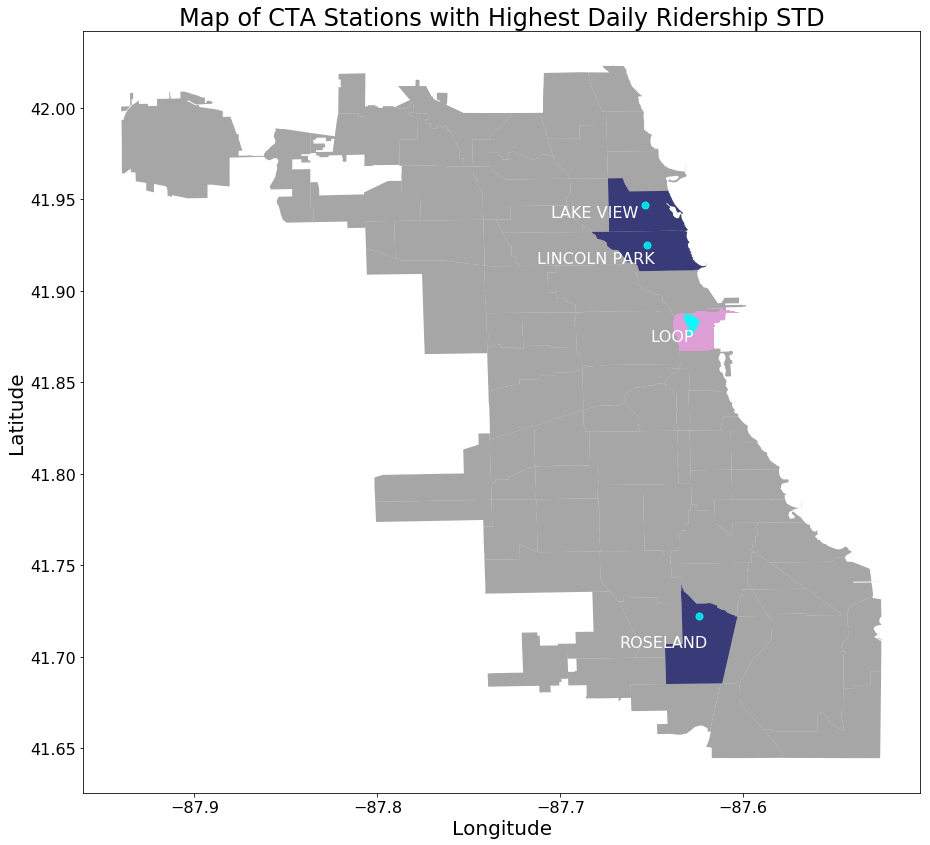

In [180]:
fig, ax = plt.subplots(figsize=(15,15))
neigh_map.plot(ax=ax,alpha=.7, color='grey')
neigh_to_station.plot(ax=ax, cmap='tab20b', column='freq')

for n, xy in zip(neighs_only['neighborhood'].tolist(), neighs_only['xy'].tolist()):
    ax.annotate(n,  xy=xy, horizontalalignment='right', verticalalignment='top',
                color='white', fontsize=16)
station_to_neigh.plot(ax=ax, color='cyan', marker='o', alpha=.8, markersize=50)
ax.set_xlabel('Longitude', fontsize=20)
ax.set_ylabel('Latitude', fontsize=20)
ax.set_xticklabels(ax.get_xticklabels(),fontsize=16)
ax.set_yticklabels(ax.get_yticklabels(),fontsize=16)
plt.title('Map of CTA Stations with Highest Daily Ridership STD', fontsize=24)
plt.savefig('figs/map_high_daily_stds.png')